# Comparing Fixed vs Optimized Hyper-Parameters on  the ExtraSensory dataset
using Cross-Validation


## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

## Import modules

In [2]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow uses a basic train/test experiment to compare the use of default hyper-parameters to optimized hyper-parameters for the same model. We use logistic regression and decision trees as the models. To optimize hyper-parameters, we wrap a base model with Scikit-Learn's grid search cross-validation wrapper to provied hyper-parameter selection via nested cross-validation. The experiment uses the first 50,000  instances in the ExtraSensory data set. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, mean imputation, and normalization. Next, the workflow includes one branch performing a train/test experiment for each model. Pre-processing is shared across all branches of the workflow. 

In the results below, we can see that logisitic regression outperforms the decision tree by more than 30% when the default hyper-parameters are used. However, the default decision tree hyper-parameters are quite poor for this task. Both models show improved performance using optimized hyper-parameters, with the decision tree improving to nearly match the performance of logistic regression. 

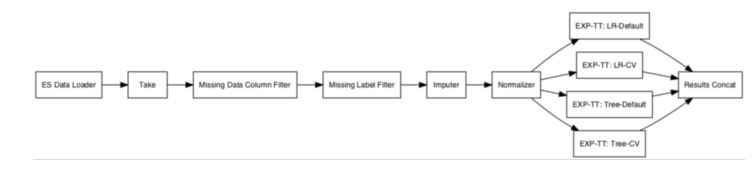

Running step ES Data Loader
  Loading Extrasensory pkl file...

Running step Take

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 37895x221

Running step Normalizer
  Normalizer: running matrix of size 37895x221

Running step EXP-TT: Tree-CV
  Fitting and testing Tree-CV
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.6s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.7s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.0s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=6, total=   1.3s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=6, total=   1.4s
[CV] max_depth=6 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   21.4s finished



Running step EXP-TT: Tree-Default
  Fitting and testing Tree-Default

Running step EXP-TT: LR-CV
  Fitting and testing LR-CV
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   3.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ........................................... C=0.01, total=   1.9s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   3.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   3.4s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   3.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   3.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   3.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   3.2s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   47.7s finished



Running step EXP-TT: LR-Default
  Fitting and testing LR-Default

Running step Results Concat
  Concatenating Results


,accuracy_score,f1_score,precision_score,recall_score
LR-Default,0.851197,0.772084,0.776243,0.767969
LR-CV,0.853440,0.776471,0.777321,0.775622
Tree-Default,0.567943,0.184527,0.242438,0.148948
Tree-CV,0.822047,0.681745,0.825243,0.580760



  Workflow complete



In [8]:
metrics     = [accuracy_score, f1_score, precision_score, recall_score]

df_raw      = extrasensory_data_loader(label="SLEEPING");
df_raw      = Take(df_raw, 50000)
df_cf       = MisingDataColumnFilter(df_raw);
df_lf       = MisingLabelFilter(df_cf);
df_imp      = Imputer(df_lf, method="mean")
df_norm     = Normalizer(df_imp)

models = {
              "LR-Default": LogisticRegression(solver="lbfgs",max_iter=1000),
              "LR-CV":      GridSearchCV(LogisticRegression(solver="lbfgs",max_iter=1000), 
                                    cv=3, verbose=2, param_grid={"C":[1e-2,1e-1,1,10,100]}),
              "Tree-Default":  tree.DecisionTreeClassifier(),
              "Tree-CV":    GridSearchCV(tree.DecisionTreeClassifier(), 
                                     cv=3, verbose=2, param_grid={"max_depth":[2,4,6,8,10]})
        }

res     = ExpTrainTest(df_norm, models, metrics=metrics);
res_cat = ResultsConcat(res)
flow    = workflow(res_cat)
 
flow.draw(); plt.show();
output=flow.run();